<a href="https://colab.research.google.com/github/Shubhkr07/CNN_DeepFake-/blob/main/cnn_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.regularizers import l1_l2
from sklearn.utils import class_weight
from PIL import Image


2024-05-30 09:14:29.025488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 09:14:29.025595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 09:14:29.127988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
training_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
testing_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'
validation_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'

In [ ]:
IMG_SIZE = (256, 256)

training_data = tf.keras.preprocessing.image_dataset_from_directory(training_dir,
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                      label_mode='categorical',
                                                                      batch_size=32,
                                                                      image_size=IMG_SIZE)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(testing_dir,
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False)


Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


True 0
False 1
True 0
False 1
False 1


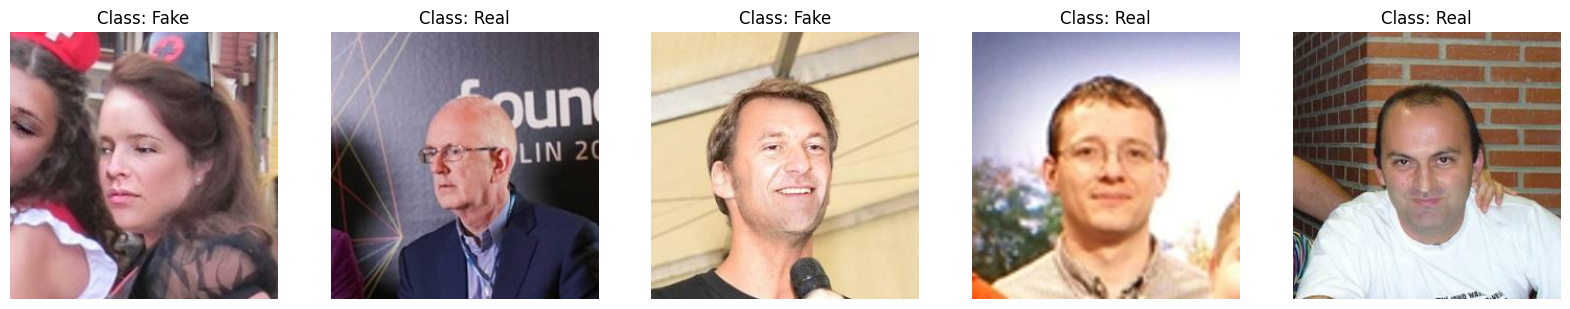

In [ ]:
for images, labels in training_data.take(1):
  # Visualize the first 'n' images
  n = 5
  plt.figure(figsize=(20, 20))
  for i in range(n):
      ax = plt.subplot(1, n, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      # Assuming you have two classes and the label [1, 0] corresponds to 'Fake' and [0, 1] to 'Real'
      label = 'Fake' if np.argmax(labels[i].numpy()) == 0 else 'Real'
      print(np.argmax(labels[i].numpy()) == 0, np.argmax(labels[i].numpy()))
      plt.title("Class: " + label)
      plt.axis("off")
  plt.show()


In [ ]:
def normalize_image(image, label):
    # Normalize the image pixels to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply the normalization function to the datasets
training_data = training_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)
testing_data = testing_data.map(normalize_image)


In [ ]:
model1 = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(256, 256, 3), kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional layer
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fourth convolutional layer - reducing kernel size
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same", kernel_constraint=MaxNorm(3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output for dense layers
    Flatten(),

    # Dense layer
    Dense(1024, activation='relu', kernel_constraint=MaxNorm(3)),
    Dropout(0.5),

    # Output layer
    Dense(2, activation='softmax')  # Softmax for binary classification
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 31, 31, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,796,226 (10.67 MB)

 Trainable params: 2,795,266 (10.66 MB)

 Non-trainable params: 960 (3.75 KB)

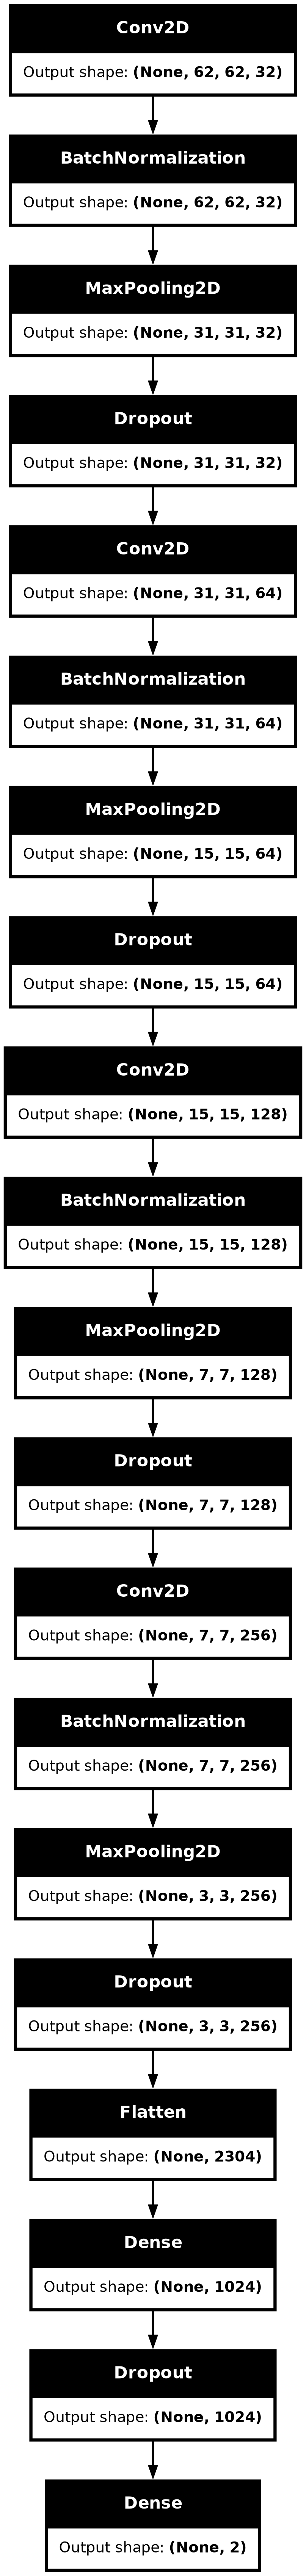

In [ ]:
plot_model(model1,show_shapes=True,to_file='cnn_architect.png')


In [ ]:
# Initial parameters
epochs = 20
initial_lrate = 0.01

# Create the SGD optimizer without the decay parameter
sgd = SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

# Function to calculate the learning rate decay
def decay(epoch, lrate):
    return initial_lrate / (1 + decay_rate * epoch)

# Calculate the decay rate
decay_rate = initial_lrate / epochs
# Create a LearningRateScheduler callback to adjust the learning rate during training
lrate_scheduler = LearningRateScheduler(lambda epoch: decay(epoch, initial_lrate))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [ ]:
history = model1.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks=[lrate_scheduler])


Epoch 1/20
   5/4376 ━━━━━━━━━━━━━━━━━━━━ 2:00 28ms/step - accuracy: 0.5927 - loss: 1.6429  

I0000 00:00:1717060725.091518     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717060725.112096     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6409 - loss: 0.8739

W0000 00:00:1717060996.095397     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717060997.445240     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 372s 82ms/step - accuracy: 0.6409 - loss: 0.8738 - val_accuracy: 0.7549 - val_loss: 0.4940 - learning_rate: 0.0100
Epoch 2/20


W0000 00:00:1717061084.030322     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 147s 33ms/step - accuracy: 0.7868 - loss: 0.4500 - val_accuracy: 0.7432 - val_loss: 0.5926 - learning_rate: 0.0100
Epoch 3/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 160s 36ms/step - accuracy: 0.8585 - loss: 0.3261 - val_accuracy: 0.8186 - val_loss: 0.4695 - learning_rate: 0.0100
Epoch 4/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 124s 28ms/step - accuracy: 0.8923 - loss: 0.2589 - val_accuracy: 0.9004 - val_loss: 0.2463 - learning_rate: 0.0100
Epoch 5/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 133s 30ms/step - accuracy: 0.9059 - loss: 0.2273 - val_accuracy: 0.9172 - val_loss: 0.2002 - learning_rate: 0.0100
Epoch 6/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 107s 24ms/step - accuracy: 0.9168 - loss: 0.2040 - val_accuracy: 0.9219 - val_loss: 0.2066 - learning_rate: 0.0100
Epoch 7/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 107s 24ms/step - accuracy: 0.9225 - loss: 0.1886 - val_accuracy: 0.9222 - val_loss: 0.1877 - learning_rate: 0.0100
Epoch 8/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 104s 24ms/step - accuracy: 

In [ ]:
model1.save('deepfake_cnn.keras')

In [ ]:
history

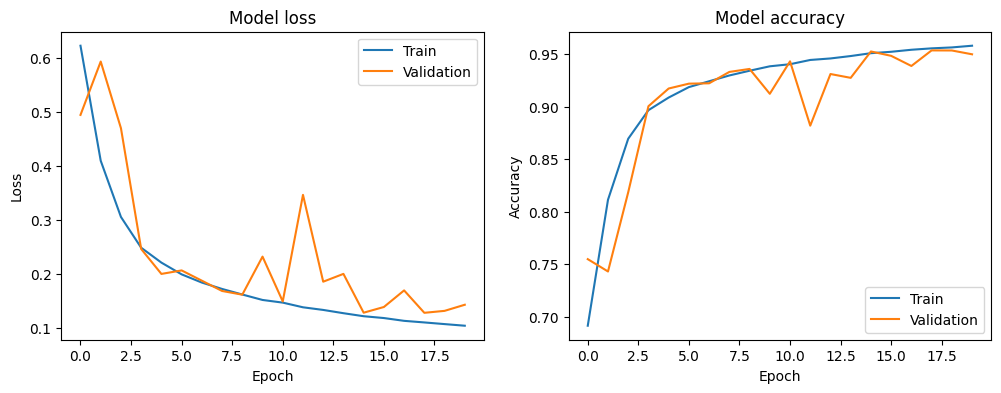

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()